### Kaggle - Web Traffic Time Series Forecasting

# Modified CNN with Fibonacci Median

**v10.7 Grouping, Ensemble, and Optimized Group Models**

by Louis Yang and Sky Huang, 2017

#### Model Explanation
We use a Fibonacci series as the window sizes to compute the a serie of median excluding nan for each sample (page). Then find again the median amount the series excluding nan. Use this median-median (which we call Fibonacci median) as the center of each sample. The Fibonaccis series we took is `[11, 18, 30, 48, 78, 126, 203, 329]`, which was suggested by Ehsan  http://www.kaggle.com/safavieh/median-estimation-by-fibonacci-et-al-lb-44-9?scriptVersionId=1466647 and has original scored 44.9 in the stage 1 Kaggle leaderboard.

To better train the neural network for various scales of dayily visits, we first do the log1p transformation in the form 
    
    X_log = log10(X_ori + 1),

to bring them into the same order. Then we sample-wise (page-wise) standardize the data using the Fibonacci median (`fib_med`) instead of regular mean as the center baseline and the usual standard deviation (`stdev`) as the scale, where `nan` is treated as `0`.

According to the Fibonacci median (`fib_med`), we split data (pages) into groups and train individual neural network (models) in each group. The group spliting is determined by `log10(fib_med + 1) < (1.0, 2.0, 4.0, greater)`. So there are total 4 groups.

The first group (group 0) use the result from the Fibonacci median model (`fib_med`) since it is difficult to learn by our neural network. For the rest groups (group 1-3), we use the results from the convolutional neural network (CNN). 

The neural network takes 64 days (`x_length`) of data and predicts the following 64 days (`y_length`) of results. For the neural network structure, we use single 1D convolutional layer with 140 neurons, kernel size 3, and relu activation function, which pass through average pooling with size 2. After the flatten the convolutional result, we feed the Fibonacci median and stdev (after log transform) for the sample as addional inputs via concatenation. Finally, the concatenated data is pass into 3 fully connected layer (130, 120, and 64 neurons) with 2 relu and 1 linear activation functions to do the regression. 

The CNN structure is: 

    [X > Conv1D(140, kernel=3) > AvgPool(2) > Flat + Additional input, A, (median, stdev)] > Concat > FC(130, relu) > FC(120, relu) > FC(64, linear) > Y

Ensemble learning: We train the same neural network 5 times. Each run only train on 4/5 of the data. Then we take the median of the result from each run.

Group model optimization: We evaluate the group models (neural network trained within their own group) on other groups data, and assign their results based on their performance in test mode. Since in the test (validation) mode the neural network model trained by group 2 do better than those trained by group 3 on group 3 data, we use the group model 2 for predicting group 3 result.

#### Usage
This notebook has two modes (controled by `test_length`): the test mode (`test_length != 0`) and the predicting mode (test_length = 0).

The default parameter of this notebook is in the predicting mode. In predicting mode, it will train on stage 2 data `'train_3.csv'` (the latest `'train_2.csv'` on Kaggle website) and output prediction required by the stage 2 of the competition. In this mode, the SMAPE scores are computed on the input set as estimation. To switch to test mode (for model self-evaluation, validation, and parameter tunning purpose), you can set the `test_length` to the lengh (days) of the ouput prediction (ex. `test_length = y_length`).

Required input files: `'train_3.csv'`, `'key_2.csv'`

#### Statistics
Runtime: 1hr20min on Intel Core i7-4700MQ

Peak memory usage: 7+ GB (durning test and training) and 9+ GB (durning output prediction)

In [1]:
model_name ='model_modified_CNN'

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc  # Python garbage collect
from tools import *

## Input

In [3]:
train_file = 'train_3.csv'

In [4]:
key_file = 'key_2.csv'

In [5]:
input_df = pd.read_csv('../data/' + train_file, nrows=1)
input_df_dates = input_df.columns[1:]; input_df_dates

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04', '2017-09-05',
       '2017-09-06', '2017-09-07', '2017-09-08', '2017-09-09', '2017-09-10'],
      dtype='object', length=803)

In [6]:
visits_dtype = {d: np.float32 for d in input_df_dates}

print('%%% Reading data '+ train_file + ' ... ', end = '', flush = True)
input_df = pd.read_csv('../data/' + train_file, engine='c', dtype=visits_dtype)
print('done!')

%%% Reading data train_3.csv ... done!


In [7]:
input_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


## Processing Data
Generate training set and test (predict) set

### Day of week alignment

In [8]:
from datetime import datetime
def weekday(datestr):
    return datetime.strptime(datestr,'%Y-%m-%d').weekday()
def daydiff(dstr1,dstr2):
    return datetime.strptime(dstr1,'%Y-%m-%d') - datetime.strptime(dstr2,'%Y-%m-%d') 

We need to predict output (Y_output_pred) start from Sunday (6) for data set 1. (0: Monday, 6: Sunday)

We take the x_length + y_length days of data only.

This part then split into x_length as input X and y_length as output Y

In [9]:
x_length = 64  # input period
y_length = 64  # predict period

In [10]:
test_length = 0  # for predicting
#test_length = y_length  # for self testing

#### X

In [11]:
X_input_dates = input_df_dates[-x_length-test_length-364:-test_length-364]

if test_length:
    X_output_dates = input_df_dates[-x_length-test_length:-test_length]
else:
    X_output_dates = input_df_dates[-x_length:]

In [12]:
print('X_input_first_day: ', X_input_dates[0], weekday(X_input_dates[0]))
print('X_input_final_day: ', X_input_dates[-1], weekday(X_input_dates[-1]))
print('X_input_days_diff: ', daydiff(X_input_dates[-1], X_input_dates[0]))

print('X_output_first_day:', X_output_dates[0], weekday(X_output_dates[0]))
print('X_output_final_day:', X_output_dates[-1], weekday(X_output_dates[-1]))
print('X_output_days_diff:', daydiff(X_output_dates[-1], X_output_dates[0]))

X_input_first_day:  2016-07-10 6
X_input_final_day:  2016-09-11 6
X_input_days_diff:  63 days, 0:00:00
X_output_first_day: 2017-07-09 6
X_output_final_day: 2017-09-10 6
X_output_days_diff: 63 days, 0:00:00


#### Submission required days

In [13]:
if test_length == 0:  # Prefetch the key_file
    output_df = pd.read_csv('../data/' + key_file, nrows=100)    # Read the first 100 days of required submission
    output_df['date'] = output_df.Page.apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date
    output_df['Page'] = output_df.Page.apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'
    print(output_df.head())

                                               Page            Id        date
0  007_スペクター_ja.wikipedia.org_all-access_all-agents  0b293039387a  2017-09-13
1  007_スペクター_ja.wikipedia.org_all-access_all-agents  7114389dd824  2017-09-14
2  007_スペクター_ja.wikipedia.org_all-access_all-agents  057b02ff1f09  2017-09-15
3  007_スペクター_ja.wikipedia.org_all-access_all-agents  bd2aca21caa3  2017-09-16
4  007_スペクター_ja.wikipedia.org_all-access_all-agents  c0effb42cdd5  2017-09-17


In [14]:
if test_length == 0:
    output_df_dates_all = output_df.date.values.astype('datetime64[D]')
    output_df_first_day = str(output_df_dates_all.min())
    output_df_final_day = str(output_df_dates_all.max())
    print('submission required first day:', output_df_first_day)
    print('submission required final day:', output_df_final_day)

submission required first day: 2017-09-13
submission required final day: 2017-11-13


#### Y

In [15]:
Y_input_dates = input_df_dates[-test_length-364:-test_length-364+y_length]

In [16]:
# Y for output set
if test_length:
    Y_output_dates = input_df_dates[-test_length:]
else:
    Y_output_first_day = '2017-09-11'  ## Make sure it is correct when predicting !!!!!!!
    Y_output_dates = pd.Index(np.arange(np.datetime64(Y_output_first_day), 
                                        np.datetime64(Y_output_first_day)
                                        + np.timedelta64(y_length, 'D')).astype('str'))

In [17]:
print('Y_input_first_day: ', Y_input_dates[0], weekday(Y_input_dates[0]))
print('Y_input_final_day: ', Y_input_dates[-1], weekday(Y_input_dates[-1]))
print('Y_input_days_diff: ', daydiff(Y_input_dates[-1], Y_input_dates[0]))

print('Y_output_first_day:', Y_output_dates[0], weekday(Y_output_dates[0]))
print('Y_output_final_day:', Y_output_dates[-1], weekday(Y_output_dates[-1]))
print('Y_output_days_diff:', daydiff(Y_output_dates[-1], Y_output_dates[0]))

Y_input_first_day:  2016-09-12 0
Y_input_final_day:  2016-11-14 0
Y_input_days_diff:  63 days, 0:00:00
Y_output_first_day: 2017-09-11 0
Y_output_final_day: 2017-11-13 0
Y_output_days_diff: 63 days, 0:00:00


## Fibonacci

#### Window Sizes

The window sizes are given by Ehsan https://www.kaggle.com/safavieh/median-estimation-by-fibonacci-et-al-lb-44-9?scriptVersionId=1466647

In [18]:
windows = [11, 18, 30, 48, 78, 126, 203, 329]
fib_length = max(windows)

#### Data selection

In this testing code, we did not include the last y_length days since in the real predicting stage, we don't know their visits.

In [19]:
if test_length:
    fib_output_dates = input_df_dates[-fib_length-test_length:-test_length]
else:
    fib_output_dates = input_df_dates[-fib_length:]
fib_input_dates = input_df_dates[-fib_length-test_length-364:-test_length-364]

In [20]:
fib_output_data = input_df[fib_output_dates].values
fib_input_data = input_df[fib_input_dates].values

#### Fibonacci median in each window

In [21]:
fib_input_median_list = np.array([np.nanmedian(fib_input_data[:, -w:] , axis=-1) 
                                  for w in windows])
fib_output_median_list = np.array([np.nanmedian(fib_output_data[:, -w:] , axis=-1) 
                                   for w in windows])
# Runtime: 22 sec

c:\python36\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [22]:
fib_input_median = np.nan_to_num(np.nanmedian(fib_input_median_list.T, axis=-1))
fib_output_median = np.nan_to_num(np.nanmedian(fib_output_median_list.T, axis=-1))

c:\python36\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [23]:
del fib_output_data
del fib_input_data
del fib_output_median_list
del fib_input_median_list
gc.collect()

349

We will use this as the center and part of the result

In [24]:
Y_input_fib = fib_input_median.reshape(-1,1)
Y_output_fib = fib_output_median.reshape(-1,1)

## Data Selection
Select x_length + y_length days of data as input or ouput set.

### Input and Output data

In [25]:
X_input_raw = input_df[X_input_dates].values
Y_input_raw = input_df[Y_input_dates].values
X_output_raw = input_df[X_output_dates].values
if test_length:
    Y_output_raw = input_df[Y_output_dates].values

##### Convert nan to number 0.

In [26]:
X_input_num = np.nan_to_num(X_input_raw)
Y_input_num = np.nan_to_num(Y_input_raw)
X_output_num = np.nan_to_num(X_output_raw)
if test_length:
    Y_output_num = np.nan_to_num(Y_output_raw)

## Transform Data

### Log

In [27]:
def log(X):
    return np.log10(X + 1.0)
def unlog(X):
    return np.clip(np.power(10., X) - 1.0, 0.0, None)

In [28]:
X_input_raw_log = log(X_input_raw)  # Contain nan
Y_input_raw_log = log(Y_input_raw)
X_output_raw_log = log(X_output_raw)
if test_length:
    Y_output_raw_log = log(Y_output_raw)

In [29]:
X_input_log = log(X_input_num)  # Do not contain nan
Y_input_log = log(Y_input_num)
X_output_log = log(X_output_num)
if test_length:
    Y_output_log = log(Y_output_num)

### Normalization (Center and Scale)

#### Center

In [30]:
output_center = log(fib_output_median).reshape(-1,1) # Fib. median as the center
input_center = log(fib_input_median).reshape(-1,1)

In [31]:
X_input_center = input_center # Use same center for X and Y
Y_input_center = input_center
X_output_center = output_center
Y_output_center = output_center

#### Choice of default scale for NaN data

In [32]:
default_input_scale = np.nanmedian(np.nanstd(X_input_raw_log, axis=-1))  # Do not include nan
default_output_scale = np.nanmedian(np.nanstd(X_output_raw_log, axis=-1))  # Do not include nan
default_scale = np.mean([default_input_scale, default_output_scale])
print('default_scale:', default_scale)

default_scale: 0.174351


c:\python36\lib\site-packages\numpy\lib\nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


#### Scale

In [33]:
# Treat nan as 0
input_scale = np.std(X_input_log, axis=-1).reshape(-1,1)
output_scale = np.std(X_output_log, axis=-1).reshape(-1,1)

input_scale[input_scale == 0.0] = default_scale  # Prevent divid by zero 
output_scale[output_scale == 0.0] = default_scale  # Prevent divid by zero 

In [34]:
X_input_scale = input_scale
Y_input_scale = input_scale
X_output_scale = output_scale
Y_output_scale = output_scale

#### Shift by Center and Scale by Scale

In [35]:
def transform(data_ori, center, scale):
    return (data_ori - center) / scale
def untransform(data, center, scale):
    return data * scale + center

In [36]:
# Normalize before nan->0
X_input = np.nan_to_num(transform(X_input_raw_log, X_input_center, input_scale))
X_output = np.nan_to_num(transform(X_output_raw_log, X_output_center, output_scale))
Y_input = np.nan_to_num(transform(Y_input_raw_log, Y_input_center, input_scale))
if test_length:
    Y_output = np.nan_to_num(transform(Y_output_raw_log, Y_output_center, output_scale))

Note:

* If we take nan_to_num before transform, we make sure the nan got transformed into 0 but not the center.
* If we take nan_to_num after transform, nan trun into the center but not 0 of the original data.

##### Check median and stdev transformations

In [37]:
def check_nan(X):
    return [x for x in X if np.isnan(x).any()]

### Group index based on scale of median (center)

In [38]:
def group_index(logx):
    if logx < 1.0: return 0
    elif logx < 2.0: return 1
    elif logx < 4.0: return 2
    else: return 3
group_index_v = np.vectorize(group_index)
gp_list = list(range(4))

In [39]:
# Group using Y center (Fib Median)
input_gp = group_index_v(Y_input_center).reshape(-1)
output_gp = group_index_v(Y_output_center).reshape(-1)

In [40]:
# group counts
gp_input_counts = [0] * len(gp_list)
for x in input_gp: gp_input_counts[x] += 1
print('gp_input_counts:', gp_input_counts)

gp_input_counts: [27413, 40041, 76815, 794]


In [41]:
# group counts
gp_output_counts = [0] * len(gp_list)
for x in output_gp: gp_output_counts[x] += 1
print('gp_output_counts:', gp_output_counts)

gp_output_counts: [25996, 43804, 74588, 675]


#### Original data

In [42]:
X_input_ori = X_input_num  # Do not contain nan
Y_input_ori = Y_input_num
X_output_ori = X_output_num
if test_length:
    Y_output_ori = Y_output_num

## Split X,Y data into groups

In [43]:
X_input_list = [X_input[input_gp == gp] for gp in gp_list]
Y_input_list = [Y_input[input_gp == gp] for gp in gp_list]
X_output_list = [X_output[output_gp == gp] for gp in gp_list]
if test_length:
    Y_output_list = [Y_output[output_gp == gp] for gp in gp_list]

## Additional input for the neural network

In [44]:
A_input = np.concatenate((Y_input_center, input_scale), axis=1)
A_output = np.concatenate((Y_output_center, output_scale), axis=1)

A_input_list = [A_input[input_gp == gp] for gp in gp_list]
A_output_list = [A_output[output_gp == gp] for gp in gp_list]

a_length = len(A_input[0])

## Dates that We don't evaluate their scores
We modify Y_output_raw so that some of the dates won't be evaluated.

In [45]:
y_eval_length = 63
y_not_eval = y_length - y_eval_length  # number of days we don't evaluate their scores
print("Number of day we don't evaluate:", y_not_eval)

Number of day we don't evaluate: 1


In [46]:
if test_length and y_not_eval > 0:
    Y_output_raw[:,:y_not_eval] = np.nan

In [47]:
if test_length and y_not_eval > 0:
    print(np.sum(~np.isnan(Y_output_raw[0])), y_eval_length, y_length)

In [48]:
if test_length and y_not_eval > 0:
    print(Y_output_raw[0:2,y_not_eval-1:y_not_eval+1])

#### Shuffle Index

In [49]:
def make_shuffle_index(n, seed=None):
    shuffle_index = np.arange(n)
    np.random.seed(seed)  # you can fix the initial seed for comparison purpose
    np.random.shuffle(shuffle_index)
    return shuffle_index

## Neural Network

In [50]:
import keras

Using TensorFlow backend.


### SMAPE
Symmetric mean absolute percentage error

https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

In [51]:
import keras.backend as K

def k_smape(y_true, y_pred):
    '''Symmetric mean absolute percentage error for keras metric'''
    diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true) + K.abs(y_pred),
                                            K.epsilon(), None))
    return 200. * K.mean(diff, axis=-1)

def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''
    diff = np.abs((y_true - y_pred) / 
                  np.clip(np.abs(y_true) + np.abs(y_pred), np.float32(1e-07), None))
    return np.float32(200.) * np.nanmean(diff, axis=axis)

### Neural Network Model
With the flavor of convolutional neural network

In [52]:
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import Reshape
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import concatenate
from keras.optimizers import Adam

In [53]:
n_ens = 5  # Number of ensembles
ens_list = list(range(n_ens))

In [54]:
#load exisiting model
load_previous_models = False  # Switch for determine whether to load the exisiting model or not
if load_previous_models:
    print('Load Previous Models')
    models_ens = [[load_model('../models/' + model_name + '-' + str(run) + '-' + str(gp) +'.h5',
                              custom_objects={'k_smape': k_smape})
                   for gp in gp_list]
                  for run in ens_list]
else: print('Not loading.')

Not loading.


#### Build neural networks

In [55]:
if not load_previous_models:
    models_ens = []
    for run in ens_list:
        print('Run', run, end=': ')
        models = []
        for gp in gp_list:
            print('Group-', gp, sep='', end=' ')
            layer_0 = Input(shape=(x_length,), name='x_input')
            layer_t = Reshape((-1, 1))(layer_0)
            layer_t = Conv1D(140, kernel_size=3, activation='relu')(layer_t)
            layer_t = AveragePooling1D(pool_size=2)(layer_t)
            layer_cnn_x = Flatten()(layer_t)

            layer_a = Input(shape=(a_length,), name='a_input')

            layer_t = concatenate([layer_cnn_x, layer_a])

            layer_t = Dense(130, activation='relu')(layer_t)
            layer_t = Dropout(0.25)(layer_t)
            layer_t = Dense(120, activation='relu')(layer_t)
            layer_t = Dropout(0.5)(layer_t)
            layer_f = Dense(y_length)(layer_t)

            model = Model(inputs=[layer_0, layer_a], outputs=layer_f)
            model.compile(optimizer='adam',
                          loss='mean_absolute_error', metrics=[k_smape])
            models.append(model)
        models_ens.append(models)
        print('')

Run 0: Group-0 Group-1 Group-2 Group-3 
Run 1: Group-0 Group-1 Group-2 Group-3 
Run 2: Group-0 Group-1 Group-2 Group-3 
Run 3: Group-0 Group-1 Group-2 Group-3 
Run 4: Group-0 Group-1 Group-2 Group-3 


In [56]:
models_ens[-1][-1].summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
x_input (InputLayer)             (None, 64)            0                                            
____________________________________________________________________________________________________
reshape_20 (Reshape)             (None, 64, 1)         0           x_input[0][0]                    
____________________________________________________________________________________________________
conv1d_20 (Conv1D)               (None, 62, 140)       560         reshape_20[0][0]                 
____________________________________________________________________________________________________
average_pooling1d_20 (AveragePoo (None, 31, 140)       0           conv1d_20[0][0]                  
___________________________________________________________________________________________

In [57]:
print('N of ensemble, N of groups:', np.array(models_ens).shape)

N of ensemble, N of groups: (5, 4)


In [58]:
epochs_list = [0,40,40,60]  # Epochs setting for each group

#### Train neural networks
Takes a few hours

In [59]:
%%time
if load_previous_models:
    print('Use Previous Model. Not training.')
else:
    hists_ens = []
    shuffle_indexs_ens = []
    for run, models in zip(ens_list, models_ens):
        print('=== Run:', run+1, '/', len(ens_list), '===')
        hists = []
        shuffle_indexs = []
        for (gp, model, X_in, Y_in, epochs, A_in) in zip(gp_list, models,
                                           X_input_list, Y_input_list, 
                                           epochs_list, A_input_list):
            print('--- Group:', gp+1, '/', len(gp_list), '---')
            
            # Shuffle data
            shuffle_index = make_shuffle_index(len(X_in))
            X_in_sh = X_in[shuffle_index]
            Y_in_sh = Y_in[shuffle_index]
            A_in_sh = A_in[shuffle_index]

            hist = model.fit([X_in_sh, A_in_sh], Y_in_sh, batch_size=128, 
                             epochs=epochs, 
                             validation_split=0.2, verbose=2)
            hists.append(hist)
            shuffle_indexs.append(shuffle_index)
        hists_ens.append(hists)
        shuffle_indexs_ens.append(shuffle_indexs)

=== Run: 1 / 5 ===
--- Group: 1 / 4 ---
Train on 21930 samples, validate on 5483 samples
--- Group: 2 / 4 ---
Train on 32032 samples, validate on 8009 samples
Epoch 1/40
9s - loss: 1.0614 - k_smape: 156.7548 - val_loss: 1.0359 - val_k_smape: 150.0568
Epoch 2/40
7s - loss: 1.0396 - k_smape: 148.7718 - val_loss: 1.0283 - val_k_smape: 146.3537
Epoch 3/40
7s - loss: 1.0338 - k_smape: 146.9182 - val_loss: 1.0255 - val_k_smape: 147.0556
Epoch 4/40
7s - loss: 1.0285 - k_smape: 145.4173 - val_loss: 1.0254 - val_k_smape: 148.6360
Epoch 5/40
7s - loss: 1.0245 - k_smape: 144.4631 - val_loss: 1.0209 - val_k_smape: 143.8284
Epoch 6/40
7s - loss: 1.0214 - k_smape: 143.8143 - val_loss: 1.0214 - val_k_smape: 142.9885
Epoch 7/40
7s - loss: 1.0179 - k_smape: 143.1638 - val_loss: 1.0169 - val_k_smape: 141.3128
Epoch 8/40
7s - loss: 1.0143 - k_smape: 142.5879 - val_loss: 1.0154 - val_k_smape: 144.7105
Epoch 9/40
7s - loss: 1.0118 - k_smape: 142.0580 - val_loss: 1.0137 - val_k_smape: 141.8030
Epoch 10/40
7

0s - loss: 1.1763 - k_smape: 137.5010 - val_loss: 1.0347 - val_k_smape: 136.8749
Epoch 8/60
0s - loss: 1.1550 - k_smape: 132.7076 - val_loss: 1.0180 - val_k_smape: 132.9849
Epoch 9/60
0s - loss: 1.1356 - k_smape: 129.0349 - val_loss: 1.0049 - val_k_smape: 131.1554
Epoch 10/60
0s - loss: 1.1192 - k_smape: 128.1690 - val_loss: 0.9977 - val_k_smape: 129.7371
Epoch 11/60
0s - loss: 1.1069 - k_smape: 124.9970 - val_loss: 0.9875 - val_k_smape: 128.2727
Epoch 12/60
0s - loss: 1.0940 - k_smape: 121.6842 - val_loss: 0.9806 - val_k_smape: 126.5921
Epoch 13/60
0s - loss: 1.0764 - k_smape: 121.5013 - val_loss: 0.9681 - val_k_smape: 126.6786
Epoch 14/60
0s - loss: 1.0623 - k_smape: 119.1700 - val_loss: 0.9560 - val_k_smape: 123.8053
Epoch 15/60
0s - loss: 1.0414 - k_smape: 116.4087 - val_loss: 0.9583 - val_k_smape: 122.3508
Epoch 16/60
0s - loss: 1.0366 - k_smape: 114.5312 - val_loss: 0.9523 - val_k_smape: 122.1795
Epoch 17/60
0s - loss: 1.0221 - k_smape: 113.8121 - val_loss: 0.9483 - val_k_smape: 

7s - loss: 0.9561 - k_smape: 135.4522 - val_loss: 1.0127 - val_k_smape: 139.5956
Epoch 35/40
7s - loss: 0.9541 - k_smape: 135.3089 - val_loss: 1.0101 - val_k_smape: 140.7823
Epoch 36/40
7s - loss: 0.9528 - k_smape: 135.3722 - val_loss: 1.0099 - val_k_smape: 139.8062
Epoch 37/40
7s - loss: 0.9507 - k_smape: 135.1830 - val_loss: 1.0129 - val_k_smape: 140.6150
Epoch 38/40
7s - loss: 0.9492 - k_smape: 134.7009 - val_loss: 1.0110 - val_k_smape: 140.3058
Epoch 39/40
7s - loss: 0.9499 - k_smape: 134.6235 - val_loss: 1.0094 - val_k_smape: 140.8899
Epoch 40/40
7s - loss: 0.9482 - k_smape: 134.6945 - val_loss: 1.0153 - val_k_smape: 141.3186
--- Group: 3 / 4 ---
Train on 61452 samples, validate on 15363 samples
Epoch 1/40
14s - loss: 1.0899 - k_smape: 128.7043 - val_loss: 1.0432 - val_k_smape: 121.9628
Epoch 2/40
13s - loss: 1.0513 - k_smape: 121.5327 - val_loss: 1.0317 - val_k_smape: 119.5025
Epoch 3/40
13s - loss: 1.0395 - k_smape: 119.6493 - val_loss: 1.0186 - val_k_smape: 115.3660
Epoch 4/40


0s - loss: 0.8187 - k_smape: 95.3754 - val_loss: 1.0340 - val_k_smape: 111.0162
Epoch 42/60
0s - loss: 0.8322 - k_smape: 97.6277 - val_loss: 1.0355 - val_k_smape: 110.8952
Epoch 43/60
0s - loss: 0.8239 - k_smape: 96.7134 - val_loss: 1.0398 - val_k_smape: 110.8153
Epoch 44/60
0s - loss: 0.8147 - k_smape: 95.2384 - val_loss: 1.0409 - val_k_smape: 111.1483
Epoch 45/60
0s - loss: 0.8182 - k_smape: 96.6090 - val_loss: 1.0393 - val_k_smape: 111.5105
Epoch 46/60
0s - loss: 0.8075 - k_smape: 94.1120 - val_loss: 1.0345 - val_k_smape: 110.7909
Epoch 47/60
0s - loss: 0.8114 - k_smape: 95.4174 - val_loss: 1.0372 - val_k_smape: 111.0750
Epoch 48/60
0s - loss: 0.8023 - k_smape: 93.8509 - val_loss: 1.0245 - val_k_smape: 109.2201
Epoch 49/60
0s - loss: 0.8056 - k_smape: 94.8539 - val_loss: 1.0428 - val_k_smape: 112.3302
Epoch 50/60
0s - loss: 0.7996 - k_smape: 94.9753 - val_loss: 1.0285 - val_k_smape: 110.4772
Epoch 51/60
0s - loss: 0.7969 - k_smape: 94.5895 - val_loss: 1.0404 - val_k_smape: 110.7606


13s - loss: 0.9460 - k_smape: 109.6420 - val_loss: 0.9663 - val_k_smape: 110.8395
Epoch 28/40
13s - loss: 0.9447 - k_smape: 109.4746 - val_loss: 0.9709 - val_k_smape: 113.8192
Epoch 29/40
13s - loss: 0.9419 - k_smape: 109.3429 - val_loss: 0.9643 - val_k_smape: 111.4181
Epoch 30/40
13s - loss: 0.9395 - k_smape: 109.0520 - val_loss: 0.9607 - val_k_smape: 111.2516
Epoch 31/40
13s - loss: 0.9375 - k_smape: 109.0189 - val_loss: 0.9626 - val_k_smape: 110.9761
Epoch 32/40
13s - loss: 0.9354 - k_smape: 108.6402 - val_loss: 0.9623 - val_k_smape: 110.2606
Epoch 33/40
13s - loss: 0.9348 - k_smape: 108.6569 - val_loss: 0.9619 - val_k_smape: 110.9266
Epoch 34/40
13s - loss: 0.9346 - k_smape: 108.6273 - val_loss: 0.9618 - val_k_smape: 110.6752
Epoch 35/40
13s - loss: 0.9319 - k_smape: 108.4298 - val_loss: 0.9638 - val_k_smape: 111.4079
Epoch 36/40
13s - loss: 0.9298 - k_smape: 108.3420 - val_loss: 0.9637 - val_k_smape: 111.5577
Epoch 37/40
13s - loss: 0.9291 - k_smape: 108.2707 - val_loss: 0.9618 - 

7s - loss: 1.0034 - k_smape: 139.7223 - val_loss: 0.9970 - val_k_smape: 141.1966
Epoch 15/40
7s - loss: 0.9982 - k_smape: 138.9774 - val_loss: 0.9948 - val_k_smape: 141.6787
Epoch 16/40
7s - loss: 0.9973 - k_smape: 138.8907 - val_loss: 0.9949 - val_k_smape: 140.4727
Epoch 17/40
7s - loss: 0.9933 - k_smape: 138.3203 - val_loss: 0.9966 - val_k_smape: 141.8183
Epoch 18/40
7s - loss: 0.9923 - k_smape: 138.2967 - val_loss: 0.9956 - val_k_smape: 140.3979
Epoch 19/40
7s - loss: 0.9901 - k_smape: 137.8365 - val_loss: 0.9966 - val_k_smape: 142.0865
Epoch 20/40
7s - loss: 0.9871 - k_smape: 137.7258 - val_loss: 0.9985 - val_k_smape: 142.2365
Epoch 21/40
7s - loss: 0.9864 - k_smape: 137.6827 - val_loss: 0.9994 - val_k_smape: 140.9391
Epoch 22/40
7s - loss: 0.9814 - k_smape: 137.2060 - val_loss: 1.0044 - val_k_smape: 144.7240
Epoch 23/40
7s - loss: 0.9821 - k_smape: 137.1696 - val_loss: 0.9970 - val_k_smape: 141.0350
Epoch 24/40
7s - loss: 0.9793 - k_smape: 136.9424 - val_loss: 0.9958 - val_k_smape

0s - loss: 0.9611 - k_smape: 109.2611 - val_loss: 1.0025 - val_k_smape: 112.8988
Epoch 22/60
0s - loss: 0.9459 - k_smape: 107.8876 - val_loss: 0.9788 - val_k_smape: 110.0052
Epoch 23/60
0s - loss: 0.9467 - k_smape: 109.5414 - val_loss: 0.9675 - val_k_smape: 108.1349
Epoch 24/60
0s - loss: 0.9267 - k_smape: 107.3545 - val_loss: 0.9720 - val_k_smape: 109.0768
Epoch 25/60
0s - loss: 0.9311 - k_smape: 105.8893 - val_loss: 0.9790 - val_k_smape: 110.9287
Epoch 26/60
0s - loss: 0.9154 - k_smape: 105.7897 - val_loss: 0.9639 - val_k_smape: 106.7785
Epoch 27/60
0s - loss: 0.9129 - k_smape: 105.0712 - val_loss: 0.9610 - val_k_smape: 107.7873
Epoch 28/60
0s - loss: 0.9016 - k_smape: 104.2845 - val_loss: 0.9455 - val_k_smape: 106.1810
Epoch 29/60
0s - loss: 0.8985 - k_smape: 104.1396 - val_loss: 0.9708 - val_k_smape: 108.8029
Epoch 30/60
0s - loss: 0.9077 - k_smape: 105.2652 - val_loss: 0.9472 - val_k_smape: 105.9798
Epoch 31/60
0s - loss: 0.8870 - k_smape: 103.2075 - val_loss: 0.9462 - val_k_smape

13s - loss: 1.0089 - k_smape: 115.6829 - val_loss: 0.9936 - val_k_smape: 113.3086
Epoch 9/40
13s - loss: 1.0057 - k_smape: 115.1670 - val_loss: 0.9912 - val_k_smape: 112.6280
Epoch 10/40
13s - loss: 1.0011 - k_smape: 114.6320 - val_loss: 0.9984 - val_k_smape: 113.9089
Epoch 11/40
13s - loss: 1.0001 - k_smape: 114.3489 - val_loss: 0.9969 - val_k_smape: 115.2248
Epoch 12/40
13s - loss: 0.9959 - k_smape: 114.0926 - val_loss: 0.9918 - val_k_smape: 114.0429
Epoch 13/40
13s - loss: 0.9925 - k_smape: 113.7959 - val_loss: 0.9912 - val_k_smape: 113.7644
Epoch 14/40
13s - loss: 0.9905 - k_smape: 113.5353 - val_loss: 0.9850 - val_k_smape: 113.4797
Epoch 15/40
13s - loss: 0.9863 - k_smape: 113.0724 - val_loss: 0.9808 - val_k_smape: 112.2486
Epoch 16/40
13s - loss: 0.9841 - k_smape: 112.8755 - val_loss: 0.9926 - val_k_smape: 115.2899
Epoch 17/40
13s - loss: 0.9807 - k_smape: 112.6983 - val_loss: 0.9806 - val_k_smape: 111.8776
Epoch 18/40
13s - loss: 0.9798 - k_smape: 112.5562 - val_loss: 0.9836 - v

0s - loss: 0.7850 - k_smape: 93.5767 - val_loss: 0.9785 - val_k_smape: 105.1815
Epoch 58/60
0s - loss: 0.7713 - k_smape: 91.8818 - val_loss: 0.9896 - val_k_smape: 105.6169
Epoch 59/60
0s - loss: 0.7674 - k_smape: 92.5915 - val_loss: 1.0023 - val_k_smape: 107.1405
Epoch 60/60
0s - loss: 0.7648 - k_smape: 92.3115 - val_loss: 0.9821 - val_k_smape: 104.5588
Wall time: 1h 11min 35s


### Save the Model

In [60]:
if not load_previous_models:
    for run in ens_list:
        for gp in gp_list:
            models_ens[run][gp].save('../models/' + model_name + '-' + str(run) + '-' + str(gp) +'.h5')

### Training History

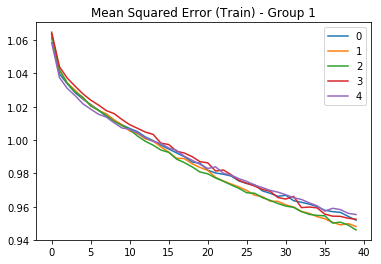

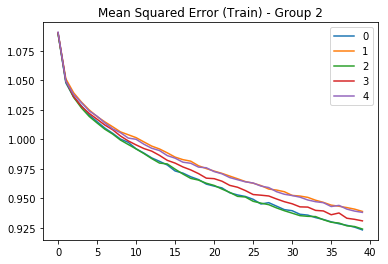

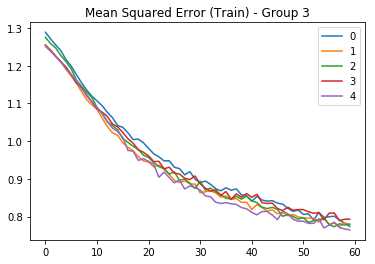

In [61]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['loss'], label=str(run))
        plt.title('Mean Squared Error (Train) - Group ' + str(gp))
        plt.legend(); plt.show()        

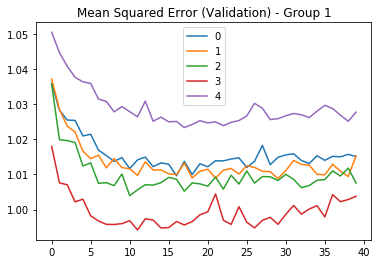

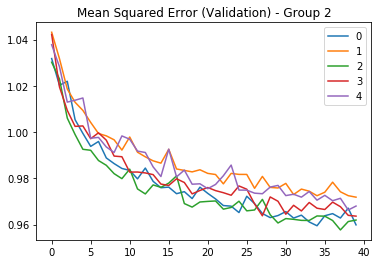

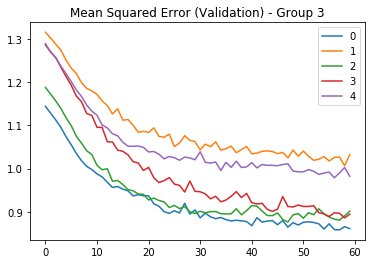

In [62]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_loss'], label=str(run))
        plt.title('Mean Squared Error (Validation) - Group ' + str(gp))
        plt.legend(); plt.show()        

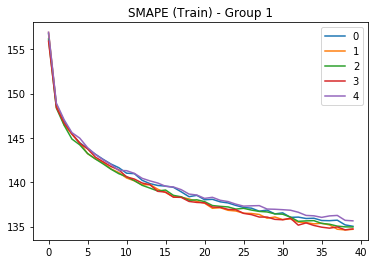

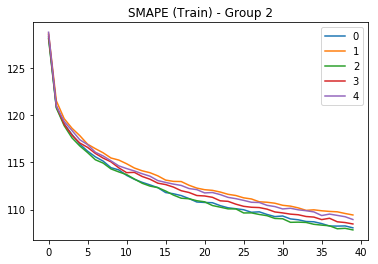

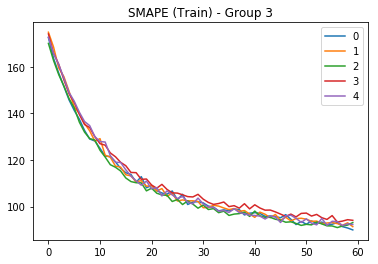

In [63]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['k_smape'], label=str(run))
        plt.title('SMAPE (Train) - Group ' + str(gp))
        plt.legend(); plt.show()        

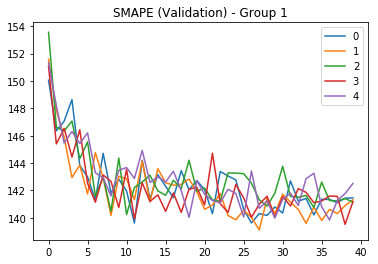

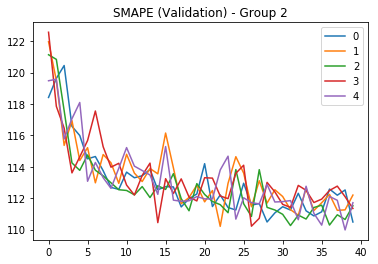

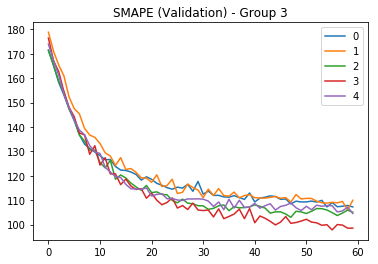

In [64]:
for gp, ep in zip(gp_list, epochs_list):
    if ep:
        for run in ens_list:
            hist = hists_ens[run][gp]
            plt.plot(hist.history['val_k_smape'], label=str(run))
        plt.title('SMAPE (Validation) - Group ' + str(gp))
        plt.legend(); plt.show()        

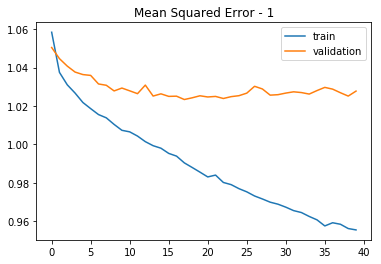

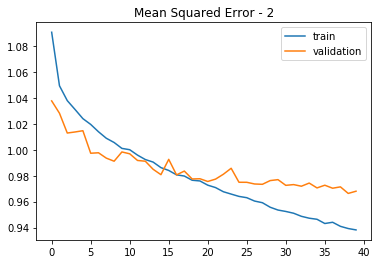

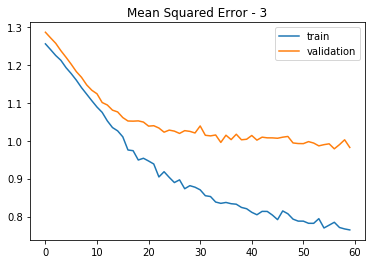

In [65]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['loss'], label='train')
        plt.plot(hist.history['val_loss'], label='validation')
        plt.title('Mean Squared Error - ' + str(gp))
        plt.legend(); plt.show()

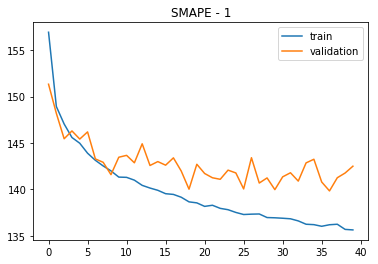

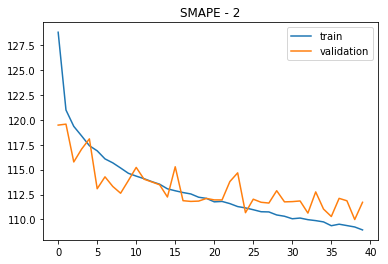

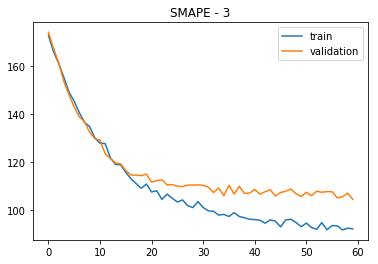

In [66]:
for (hist, gp, ep) in zip(hists, gp_list, epochs_list):
    if ep:
        plt.plot(hist.history['k_smape'], label='train')
        plt.plot(hist.history['val_k_smape'], label='validation')
        plt.title('SMAPE - ' + str(gp))
        plt.legend(); plt.show()

## Predict for Input Set (Training Set)

In [71]:
%%time
Y_input_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_input_pred_list = []
    for (gp, model, X, A) in zip(gp_list, models, X_input_list, A_input_list):
        print(gp, end=' ')
        Y_input_pred_list.append(model.predict([X, A]))
    Y_input_pred_list_ens.append(Y_input_pred_list)
    print('')

Run 0: 0 1 2 3 
Run 1: 0 1 2 3 
Run 2: 0 1 2 3 
Run 3: 0 1 2 3 
Run 4: 0 1 2 3 
Wall time: 1min 7s


In [72]:
input_index_range = np.arange(len(input_gp)); #input_index_range

In [73]:
# list for original index
input_index_list = [input_index_range[input_gp == gp] 
                     for gp in gp_list]

In [74]:
for o in input_index_list:
    print(o.shape, end=' ')

(27413,) (40041,) (76815,) (794,) 

In [75]:
input_index_list_comb = np.concatenate(input_index_list); #input_index_list_comb

In [76]:
Y_input_pred_ens = []
for Y_input_pred_list in Y_input_pred_list_ens:
    Y_input_pred_comb = np.concatenate(Y_input_pred_list)
    Y_input_pred = [0]*len(input_index_list_comb)

    for index, y in zip(input_index_list_comb, Y_input_pred_comb):
        Y_input_pred[index] = y

    Y_input_pred = np.array(Y_input_pred)  # make it an numpy array (which will also make a copy)
    Y_input_pred_ens.append(Y_input_pred)

del Y_input_pred_comb

In [77]:
# Inverse transform Y_input_pred to original Y
Y_input_pred_ori_ens = []
for Y_input_pred in Y_input_pred_ens:
    Y_input_pred_ori = unlog(untransform(Y_input_pred, Y_input_center, Y_input_scale))
    Y_input_pred_ori_ens.append(Y_input_pred_ori)

In [78]:
Y_input_pred_ori_ens = np.array(Y_input_pred_ori_ens)

## Predict for Output Set

In [79]:
%%time
Y_output_pred_list_ens = []
for models, run in zip(models_ens, ens_list):
    print('Run', run, end=': ')
    Y_output_pred_list = []
    for (gp, model, X, A) in zip(gp_list, models, X_output_list, A_output_list):
        print(gp, end=' ')
        Y_output_pred_list.append(model.predict([X, A], batch_size=4096*2))
    Y_output_pred_list_ens.append(Y_output_pred_list)
    print('')

Run 0: 0 1 2 3 
Run 1: 0 1 2 3 
Run 2: 0 1 2 3 
Run 3: 0 1 2 3 
Run 4: 0 1 2 3 
Wall time: 44.3 s


Find the original index

In [80]:
# list for original index
output_index_list = [np.arange(len(output_gp))[output_gp == gp] for gp in gp_list]
output_index_list_comb = np.concatenate(output_index_list)

In [81]:
Y_output_pred_ens = []
for Y_output_pred_list in Y_output_pred_list_ens:
    Y_output_pred_comb = np.concatenate(Y_output_pred_list)
    Y_output_pred = [0]*len(output_index_list_comb)

    for index, y in zip(output_index_list_comb, Y_output_pred_comb):
        Y_output_pred[index] = y

    Y_output_pred = np.array(Y_output_pred)  # make it an numpy array (which will also make a copy)
    Y_output_pred_ens.append(Y_output_pred)

del Y_output_pred_comb

In [82]:
# Inverse transform Y_output_pred to original Y
Y_output_pred_ori_ens = []
for Y_output_pred in Y_output_pred_ens:
    Y_output_pred_ori = unlog(untransform(Y_output_pred, 
                                          Y_output_center, Y_output_scale))
    Y_output_pred_ori_ens.append(Y_output_pred_ori)

In [83]:
Y_output_pred_ori_ens = np.array(Y_output_pred_ori_ens)

## SMAPE Scores

### Model Score

In [84]:
# SMAPE scores for the model
if test_length:
    model_smape_ens = []
    model_smape_0_ens = []
    for Y_output_pred_ori in Y_output_pred_ori_ens:
        model_smape = smape(Y_output_raw, Y_output_pred_ori) # SMAPE score excluding nan (Correct one)
        model_smape_0 = smape(Y_output_ori, Y_output_pred_ori) # SMAPE assuming nan == 0
        
        model_smape_ens.append(model_smape)
        model_smape_0_ens.append(model_smape_0)
    model_smape_ens_mean = np.mean(model_smape_ens)
    model_smape_0_ens_mean = np.mean(model_smape_0_ens)
    
    model_smape_stdev = np.std(model_smape_ens)  # standard deviation of the smape score
    model_smape_0_stdev = np.std(model_smape_0_ens)  # standard deviation of the smape score
    
    model_smape_ens_mean_std = model_smape_stdev / np.sqrt(len(model_smape_ens))

In [85]:
if test_length:
    for model_smape, model_smape_0 in zip(model_smape_ens, model_smape_0_ens):
        print('%6.3f' % model_smape, '       ', '%6.3f' % model_smape_0)
    print('-----------------------------')
    print('%6.3f' % model_smape_ens_mean, '+-%5.3f' % model_smape_stdev, 
          '%6.3f' % model_smape_0_ens_mean, '+-%5.3f' % model_smape_0_stdev)
    print('+-%5.3f' % model_smape_ens_mean_std)

In [86]:
# SMAPE score for Fibonacci median
if test_length:
    fib_smape = smape(Y_output_raw, Y_output_fib)
    print(fib_smape)

In [87]:
esmape = smape

In [88]:
# Estimated SMAPE scores for the model using training set
model_esmape_ens = []
model_esmape_0_ens = []
for Y_input_pred_ori in Y_input_pred_ori_ens:
    model_esmape = esmape(Y_input_raw, Y_input_pred_ori) # SMAPE score excluding nan (Correct one)
    model_esmape_0 = esmape(Y_input_ori, Y_input_pred_ori) # SMAPE assuming nan == 0
    
    model_esmape_ens.append(model_esmape)
    model_esmape_0_ens.append(model_esmape_0)
model_esmape_ens_mean = np.mean(model_esmape_ens)
model_esmape_0_ens_mean = np.mean(model_esmape_0_ens)

model_esmape_stdev = np.std(model_esmape_ens)  # standard deviation of the esmape score
model_esmape_0_stdev = np.std(model_esmape_0_ens)  # standard deviation of the esmape score

model_esmape_ens_mean_std = model_esmape_stdev / np.sqrt(len(model_esmape_ens))

In [89]:
for model_esmape, model_esmape_0 in zip(model_esmape_ens, model_esmape_0_ens):
    print('%6.3f' % model_esmape, '       ', '%6.3f' % model_esmape_0)
print('-----------------------------')
print('%6.3f' % model_esmape_ens_mean, '+-%5.3f' % model_esmape_stdev, 
      '%6.3f' % model_esmape_0_ens_mean, '+-%5.3f' % model_esmape_0_stdev)
print('+-%5.3f' % model_esmape_ens_mean_std)

39.099         42.530
39.394         42.853
39.057         42.599
39.262         42.757
39.431         42.772
-----------------------------
39.249 +-0.151 42.702 +-0.119
+-0.067


In [90]:
# SMAPE Est score for Fibonacci median
fib_esmape = esmape(Y_input_raw, Y_input_fib)
print(fib_esmape)

47.3282


### Group Scores

In [91]:
# Prediction Y_input in group
Y_input_pred_ori_list_ens = [[Y_input_pred_ori[input_gp == gp] for gp in gp_list]
                              for Y_input_pred_ori in Y_input_pred_ori_ens]
# Prediction Y_output in group
Y_output_pred_ori_list_ens = [[Y_output_pred_ori[output_gp == gp] for gp in gp_list]
                              for Y_output_pred_ori in Y_output_pred_ori_ens]

In [92]:
# Fibonacci median in group
Y_input_fib_list = [Y_input_fib[input_gp == gp] for gp in gp_list]
Y_output_fib_list = [Y_output_fib[output_gp == gp] for gp in gp_list]

In [93]:
# True Y_input in group
# untransformed Y_input with NaN replaced by 0
Y_input_ori_list = [Y_input_ori[input_gp == gp] for gp in gp_list]
# untransformed Y_input_ori with raw NaN (for SMAPE estimation)
Y_input_raw_list = [Y_input_raw[input_gp == gp] for gp in gp_list]

In [94]:
# True Y_output in group
if test_length:
    # untransformed Y_input with NaN replaced by 0
    Y_output_ori_list = [Y_output_ori[output_gp == gp] for gp in gp_list]
    # untransformed Y_input_ori with raw NaN (for SMAPE estimation)
    Y_output_raw_list = [Y_output_raw[output_gp == gp] for gp in gp_list]

In [95]:
# Group estimated scores (input set) for the model
gp_input_n = [len(Y) for Y in Y_input_raw_list]
# SMAPE with nan values ignored (used by Kaggle)
gp_esmape_ens = [[esmape(Y, Y_p) for Y, Y_p in zip(Y_input_raw_list, Y_input_pred_ori_list)]
                for Y_input_pred_ori_list in Y_input_pred_ori_list_ens]
gp_esmape = gp_esmape_ens[-1]    
gp_esmape_mean = np.mean(gp_esmape_ens, axis=0)
print('Input set group SMAPE:', gp_esmape_mean)

Input set group SMAPE: [ 70.25056458  40.66552734  29.4707489   23.56356812]


In [96]:
# Group scores (output set) for the model
if test_length:
    gp_output_n = [len(Y) for Y in Y_output_raw_list]
    # SMAPE with nan values ignored (used by Kaggle)
    gp_smape_ens = [[smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_list)]
                    for Y_output_pred_ori_list in Y_output_pred_ori_list_ens]
    gp_smape = gp_smape_ens[-1]    
    gp_smape_mean = np.mean(gp_smape_ens, axis=0)
    print('Output set group SMAPE:', gp_smape_mean)

In [97]:
# Group Estimated score (input set) for Fibonacci median
gp_esmape_fib = [esmape(Y, Y_p) for Y, Y_p in zip(Y_input_raw_list, Y_input_fib_list)]

In [98]:
# Group score (output set) for Fibonacci median
if test_length:
    gp_smape_fib = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_fib_list)]

In [99]:
#Estimated gp_score compare
print('#### ' + model_name, 'Estimated SMAPE (input set)')
print('', end='|')
print('N_pages ', 'Fibonacci', ' Average ', sep='|', end='|')
for run in ens_list: print(' Model', run, end=' |')
print('')
print('', end='|')
print('--------', '---------', '---------', sep='|', end='|')
for run in ens_list: print('---------', end='|')
print('')
for gp in gp_list:
    print('', end='|')
    print(' %6d ' % gp_input_n[gp], end='|')
    print(' %7.3f ' % gp_esmape_fib[gp], end='|')
    print(' %7.3f ' % gp_esmape_mean[gp], end='|')
    for run in ens_list:
        print(' %7.3f ' % gp_esmape_ens[run][gp], end='|')
    print('')
print('|  Total ', ' %7.3f ' % fib_esmape, ' %7.3f ' % model_esmape_ens_mean, sep='|', end='|')
for run in ens_list:
        print(' %7.3f ' % model_esmape_ens[run], end='|')

#### model_modified_CNN Estimated SMAPE (input set)
|N_pages |Fibonacci| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|
|  27413 |  67.261 |  70.251 |  70.304 |  70.138 |  70.179 |  70.514 |  70.119 |
|  40041 |  47.214 |  40.666 |  40.744 |  40.528 |  40.440 |  40.729 |  40.887 |
|  76815 |  41.531 |  29.471 |  29.143 |  29.842 |  29.265 |  29.382 |  29.722 |
|    794 |  41.575 |  23.564 |  23.454 |  23.480 |  23.019 |  23.754 |  24.110 |
|  Total |  47.328 |  39.249 |  39.099 |  39.394 |  39.057 |  39.262 |  39.431 |

In [100]:
if test_length:  # gp_score compare
    print('#### ' + model_name, 'SMAPE (output set)')
    print('', end='|')
    print('N_pages ', 'Fibonacci', ' Average ', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_output_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')
    print('|  Total ', ' %7.3f ' % fib_smape, ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')
    for run in ens_list:
            print(' %7.3f ' % model_smape_ens[run], end='|')

We see Fibonacci median method do better in group 0.

## Prediction Pre Combine
Combine the result of the group 0 from Fibonacci median and the rest from the CNN model

In [101]:
# Select group 0 from Fibonacci median model
fib_mask = (output_gp == 0).reshape(-1,1)

In [102]:
Y_output_fib_ori = np.repeat(Y_output_fib, y_length, axis=1)
Y_input_fib_ori = np.repeat(Y_input_fib, y_length, axis=1)

In [103]:
# The combined result for input set
Y_input_fmc_ori_ens = []
for Y_input_pred_ori in Y_input_pred_ori_ens:
    Y_input_fmc_ori = fib_mask * Y_input_fib_ori + (~fib_mask) * Y_input_pred_ori
    Y_input_fmc_ori_ens.append(Y_input_fmc_ori)

In [104]:
# The combined result
Y_output_fmc_ori_ens = []
for Y_output_pred_ori in Y_output_pred_ori_ens:
    Y_output_fmc_ori = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori
    Y_output_fmc_ori_ens.append(Y_output_fmc_ori)

#### Pre Combined Score

In [105]:
if test_length: 
    fmc_smape_ens = []
    for Y_output_fmc_ori in Y_output_fmc_ori_ens:
        fmc_smape = smape(Y_output_fmc_ori, Y_output_raw)
        fmc_smape_ens.append(fmc_smape)        
    fmc_smape_ens_mean = np.mean(fmc_smape_ens)

In [106]:
fmc_esmape_ens = []
for Y_input_fmc_ori in Y_input_fmc_ori_ens:
    fmc_esmape = esmape(Y_input_fmc_ori, Y_input_raw)
    fmc_esmape_ens.append(fmc_esmape)        
fmc_esmape_ens_mean = np.mean(fmc_esmape_ens)

In [107]:
print('### Group combined SMAPE for input set')
for run, fmc_esmape, model_esmape in zip(ens_list, fmc_esmape_ens, model_esmape_ens):
    print('%6.3f' % fmc_esmape, '(%6.3f)' % model_esmape, '-', model_name, 'Est', run)
print('%6.3f' % fmc_esmape_ens_mean, '(%6.3f)' % model_esmape_ens_mean, '-', model_name, 'Est', 'Average')

### Group combined SMAPE for input set
38.859 (39.099) - model_modified_CNN Est 0
39.194 (39.394) - model_modified_CNN Est 1
38.846 (39.057) - model_modified_CNN Est 2
38.997 (39.262) - model_modified_CNN Est 3
39.225 (39.431) - model_modified_CNN Est 4
39.024 (39.249) - model_modified_CNN Est Average


In [108]:
if test_length: 
    print('### Group combined SMAPE for output set')
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')

## Ensemble Learning

### Ensemble Median
Take ensemble median amount all the CNN models.

In [109]:
Y_input_pred_ori_ens_med = np.median(Y_input_pred_ori_ens, axis=0)
Y_output_pred_ori_ens_med = np.median(Y_output_pred_ori_ens, axis=0)

In [110]:
ens_med_esmape = esmape(Y_input_pred_ori_ens_med, Y_input_raw)
print('Ensemble SMAPE for input set:', ens_med_esmape)
if test_length:
    ens_med_smape = smape(Y_output_pred_ori_ens_med, Y_output_raw)
    print('Ensemble SMAPE for input set:', ens_med_smape)

Ensemble SMAPE for input set: 38.6974


### Ensemble Group Combined with Fibonacci Median

In [111]:
Y_input_f_omed  = fib_mask * Y_input_fib_ori + (~fib_mask) * Y_input_pred_ori_ens_med
Y_output_f_omed  = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_pred_ori_ens_med

## All Model Scores

In [112]:
# Ensemble Group Combined SMAPE for input set
f_omed_esmape = esmape(Y_input_raw, Y_input_f_omed)
if test_length:  # Ensemble Group Combined SMAPE for output set
    f_omed_smape = smape(Y_output_raw, Y_output_f_omed)

In [113]:
print('### Ensemble Group combined SMAPE for input set')
print('%6.3f' % f_omed_esmape, '(%6.3f)' % ens_med_esmape,'-', model_name, 'Est', 'ori_ensemble_median')
print('%6.3f' % fmc_esmape_ens_mean, '(%6.3f)' % model_esmape_ens_mean, '-', model_name, 'Est', 'Average')
for run, fmc_esmape, model_esmape in zip(ens_list, fmc_esmape_ens, model_esmape_ens):
    print('%6.3f' % fmc_esmape, '(%6.3f)' % model_esmape, '-', model_name, 'Est', run)

### Ensemble Group combined SMAPE for input set
38.526 (38.697) - model_modified_CNN Est ori_ensemble_median
39.024 (39.249) - model_modified_CNN Est Average
38.859 (39.099) - model_modified_CNN Est 0
39.194 (39.394) - model_modified_CNN Est 1
38.846 (39.057) - model_modified_CNN Est 2
38.997 (39.262) - model_modified_CNN Est 3
39.225 (39.431) - model_modified_CNN Est 4


In [114]:
if test_length:
    print('### Ensemble Group combined SMAPE for output set')
    print('%6.3f' % f_omed_smape, '(%6.3f)' % ens_med_smape,'-', model_name, 'ori_ensemble_median')
    print('%6.3f' % fmc_smape_ens_mean, '(%6.3f)' % model_smape_ens_mean, '-', model_name, 'Average')
    for run, fmc_smape, model_smape in zip(ens_list, fmc_smape_ens, model_smape_ens):
        print('%6.3f' % fmc_smape, '(%6.3f)' % model_smape, '-', model_name, run)

## All Group Scores

In [115]:
# ensemble result Y_input in each group
Y_input_pred_ori_ens_med_list = [Y_input_pred_ori_ens_med[input_gp == gp] for gp in gp_list]

# ensemble result Y_output in each group
Y_output_pred_ori_ens_med_list = [Y_output_pred_ori_ens_med[output_gp == gp] for gp in gp_list]

In [116]:
# Group Estimated SMAPE scores
gp_omed_esmape = [esmape(Y, Y_p) for Y, Y_p in zip(Y_input_raw_list, Y_input_pred_ori_ens_med_list)]
# Group SMAPE scores
if test_length:
    gp_omed_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_pred_ori_ens_med_list)]

In [117]:
# The Estimated gp score
print('#### ' + model_name, 'Estimated')
print('', end='|')
print(' N_pages', 'Fibonacci', 'Ens Media', ' Average ', sep='|', end='|')
for run in ens_list: print(' Model', run, end=' |')
print('')
print('', end='|')
print('--------', '---------', '---------', '---------', sep='|', end='|')
for run in ens_list: print('---------', end='|')
print('')
for gp in gp_list:
    print('', end='|')
    print(' %6d ' % gp_input_n[gp], end='|')
    print(' %7.3f ' % gp_esmape_fib[gp], end='|')
    print(' %7.3f ' % gp_omed_esmape[gp], end='|')
    print(' %7.3f ' % gp_esmape_mean[gp], end='|')
    for run in ens_list:
        print(' %7.3f ' % gp_esmape_ens[run][gp], end='|')
    print('')
print('|Over All', ' %7.3f ' % fib_esmape, ' %7.3f ' % f_omed_esmape,
      ' %7.3f ' % model_esmape_ens_mean, sep='|', end='|')
for run in ens_list:
        print(' %7.3f ' % model_esmape_ens[run], end='|')

# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

#### model_modified_CNN Estimated
| N_pages|Fibonacci|Ens Media| Average | Model 0 | Model 1 | Model 2 | Model 3 | Model 4 |
|--------|---------|---------|---------|---------|---------|---------|---------|---------|
|  27413 |  67.261 |  69.984 |  70.251 |  70.304 |  70.138 |  70.179 |  70.514 |  70.119 |
|  40041 |  47.214 |  40.085 |  40.666 |  40.744 |  40.528 |  40.440 |  40.729 |  40.887 |
|  76815 |  41.531 |  28.860 |  29.471 |  29.143 |  29.842 |  29.265 |  29.382 |  29.722 |
|    794 |  41.575 |  22.059 |  23.564 |  23.454 |  23.480 |  23.019 |  23.754 |  24.110 |
|Over All|  47.328 |  38.526 |  39.249 |  39.099 |  39.394 |  39.057 |  39.262 |  39.431 |

In [118]:
if test_length:  # The_gp_score
    print('#### ' + model_name)
    print('', end='|')
    print(' N_pages', 'Fibonacci', 'Ens Media', ' Average ', sep='|', end='|')
    for run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', '---------', sep='|', end='|')
    for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_output_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_omed_smape[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        for run in ens_list:
            print(' %7.3f ' % gp_smape_ens[run][gp], end='|')
        print('')
    print('|Over All', ' %7.3f ' % fib_smape, ' %7.3f ' % f_omed_smape,
          ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')
    for run in ens_list:
            print(' %7.3f ' % model_smape_ens[run], end='|')

# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

## Optimize Group Models
Pages in one group could be predicted better by the models trained in other groups.

### Group Models in other Groups

In [119]:
%%time
if test_length == 0:
    Y_input_all_ori_list_ens = unlog(np.array([[untransform(model.predict([X_input, A_input], batch_size=4096*2), 
                                                            Y_input_center, input_scale) 
                                                for model in models] for models in models_ens]))
#Takes 4 min on PC and NB

Wall time: 3min 1s


In [120]:
%%time
Y_output_all_ori_list_ens = unlog(np.array([[untransform(model.predict([X_output, A_output], batch_size=4096*2), 
                                                         Y_output_center, output_scale) 
                                             for model in models] for models in models_ens]))
#Takes 4 min on PC and NB

Wall time: 3min 2s


In [121]:
#Take Ensemble median
Y_output_all_ori_list_ens_med = np.median(Y_output_all_ori_list_ens, axis=0)
if test_length == 0:
    Y_input_all_ori_list_ens_med = np.median(Y_input_all_ori_list_ens, axis=0)

In [122]:
#Group SMAPE for each group models (input set)
#row index: group model; column index: group of Y
if test_length == 0:
    esmape_gpm_gp_ens_med = [[esmape(Y, Y_p[input_gp == gp]) for gp, Y in zip(gp_list, Y_input_raw_list)] 
                            for Y_p in Y_input_all_ori_list_ens_med]

In [123]:
#Group SMAPE for each group models (output set)
#row index: group model; column index: group of Y
if test_length:
    smape_gpm_gp_ens_med = [[smape(Y, Y_p[output_gp == gp]) for gp, Y in zip(gp_list, Y_output_raw_list)] 
                            for Y_p in Y_output_all_ori_list_ens_med]

In [124]:
if test_length:
    print('Ens. Median   ', end='|')
    for j in range(len(smape_gpm_gp_ens_med[0])): print(' group', j, end='|')
    print('')
    print('--------------', end='|')
    for j in range(len(smape_gpm_gp_ens_med[0])): print('--------', end='|')
    print('')
    for i in range(len(smape_gpm_gp_ens_med)):
        print('group model', i, end=' |')
        for j in range(len(smape_gpm_gp_ens_med[0])):
            print(' %6.2f ' % smape_gpm_gp_ens_med[i][j], end='|')
        print('')
else:
    print('Ens. Median   ', end='|')
    for j in range(len(esmape_gpm_gp_ens_med[0])): print(' group', j, end='|')
    print('')
    print('--------------', end='|')
    for j in range(len(esmape_gpm_gp_ens_med[0])): print('--------', end='|')
    print('')
    for i in range(len(esmape_gpm_gp_ens_med)):
        print('group model', i, end=' |')
        for j in range(len(esmape_gpm_gp_ens_med[0])):
            print(' %6.2f ' % esmape_gpm_gp_ens_med[i][j], end='|')
        print('')

Ens. Median   | group 0| group 1| group 2| group 3|
--------------|--------|--------|--------|--------|
group model 0 |  69.98 |  47.23 |  41.56 |  41.67 |
group model 1 |  69.90 |  40.08 |  36.06 |  40.77 |
group model 2 |  73.06 |  44.14 |  28.86 |  29.83 |
group model 3 |  79.95 |  52.05 |  39.49 |  22.06 |


In validation mode, group 3 do better in group model 2.

In [125]:
if test_length: 
    for x in gp_omed_smape: print(' %6.2f ' % x, end='|')
else: 
    for x in gp_omed_esmape: print(' %6.2f ' % x, end='|')

  69.98 |  40.08 |  28.86 |  22.06 |

In [126]:
if test_length: 
    for x in gp_smape_fib: print(' %6.2f ' % x, end='|')
else: 
    for x in gp_esmape_fib: print(' %6.2f ' % x, end='|')

  67.26 |  47.21 |  41.53 |  41.57 |

### Optimized Group Models

In [127]:
if test_length:
    gpm_list = np.argmin(smape_gpm_gp_ens_med,axis=0)
else:
    gpm_list = np.array([0,1,2,2])  # Use group model 2 for group 3

print('Optimized group model list = [', end='')
for x in gpm_list: print(x, end=',')
print(']')

Optimized group model list = [0,1,2,2,]


In [128]:
gpm_mask = np.array([gpm_list == gp for gp in gp_list]).T
Y_output_ori_list_ens_med_temp = np.tensordot(gpm_mask, Y_output_all_ori_list_ens_med, axes=([1],[0]))

In [129]:
gp_mask = np.array([output_gp == gp for gp in gp_list])
gp_mask = gp_mask.reshape(len(gp_mask), len(gp_mask[0]), 1)
Y_output_ori_list_ens_med_temp_mask = gp_mask * Y_output_ori_list_ens_med_temp
Y_output_gpm_ens_med = np.sum(Y_output_ori_list_ens_med_temp_mask, axis=0)

In [130]:
del Y_output_ori_list_ens_med_temp
del Y_output_ori_list_ens_med_temp_mask

In [131]:
if test_length: 
    gpm_ens_smape = smape(Y_output_raw, Y_output_gpm_ens_med)
    print(gpm_ens_smape, ens_med_smape)

#### Group scores

In [132]:
if test_length: Y_output_gpm_ens_med_list = [Y_output_gpm_ens_med[output_gp == gp] for gp in gp_list]

In [133]:
# Group SMAPE scores
if test_length:
    gp_gpm_ens_med_smape = [smape(Y, Y_p) for Y, Y_p in zip(Y_output_raw_list, Y_output_gpm_ens_med_list)]

In [134]:
if test_length:
    #print('#### ' + model_name + 'group model optimized')
    #print('', end='|')
    print(' N_pages', 'Fibonacci', 'GPM Optim', 'Ens Media', ' Average ', sep='|', end='|')
    #or run in ens_list: print(' Model', run, end=' |')
    print('')
    print('', end='|')
    print('--------', '---------', '---------', '---------', '---------', sep='|', end='|')
    #for run in ens_list: print('---------', end='|')
    print('')
    for gp in gp_list:
        print('', end='|')
        print(' %6d ' % gp_output_n[gp], end='|')
        print(' %7.3f ' % gp_smape_fib[gp], end='|')
        print(' %7.3f ' % gp_gpm_ens_med_smape[gp], end='|')
        print(' %7.3f ' % gp_omed_smape[gp], end='|')
        print(' %7.3f ' % gp_smape_mean[gp], end='|')
        print('')
    #print('|Over All', ' %7.3f ' % fib_smape, ' %7.3f ' % f_omed_smape,
    #      ' %7.3f ' % model_smape_ens_mean, sep='|', end='|')    
# Note The over all score for ensemble median (Ens Media) is the one after combining with 
# Fibonacci median model not the total score

#### Combined with Fibonacci Median Result
Our final output prediction

In [135]:
# Our final output prediction
Y_output_f_gpm = fib_mask * Y_output_fib_ori + (~fib_mask) * Y_output_gpm_ens_med

In [136]:
if test_length:  # SMAPE for final output set
    f_gpm_ens_smape = smape(Y_output_raw, Y_output_f_gpm)
    print('%6.3f' % f_gpm_ens_smape, '(%6.3f)' % gpm_ens_smape, '-', model_name, 'GPM Optim Ens')

### Free some memory

In [137]:
del Y_input_log
del Y_input_raw_log
del Y_input_pred
del Y_input_pred_ori
del Y_input_pred_ori_ens
del Y_input_pred_ori_ens_med
del Y_input_fib_ori
del Y_input_fmc_ori
del Y_input_f_omed
del Y_input_all_ori_list_ens_med
gc.collect()

87356

In [138]:
if test_length == 0: del Y_input_all_ori_list_ens
gc.collect()

0

In [139]:
%whos ndarray

Variable                        Type       Data/Info
----------------------------------------------------
A                               ndarray    675x2: 1350 elems, type `float32`, 5400 bytes
A_in                            ndarray    794x2: 1588 elems, type `float32`, 6352 bytes
A_in_sh                         ndarray    794x2: 1588 elems, type `float32`, 6352 bytes
A_input                         ndarray    145063x2: 290126 elems, type `float32`, 1160504 bytes (1.1067428588867188 Mb)
A_output                        ndarray    145063x2: 290126 elems, type `float32`, 1160504 bytes (1.1067428588867188 Mb)
X                               ndarray    675x64: 43200 elems, type `float32`, 172800 bytes (168.75 kb)
X_in                            ndarray    794x64: 50816 elems, type `float32`, 203264 bytes (198.5 kb)
X_in_sh                         ndarray    794x64: 50816 elems, type `float32`, 203264 bytes (198.5 kb)
X_input                         ndarray    145063x64: 9284032 elems, typ

## Output Prediction
For predicting stage only

### Result DataFrame

In [140]:
Y_output_dates

Index(['2017-09-11', '2017-09-12', '2017-09-13', '2017-09-14', '2017-09-15',
       '2017-09-16', '2017-09-17', '2017-09-18', '2017-09-19', '2017-09-20',
       '2017-09-21', '2017-09-22', '2017-09-23', '2017-09-24', '2017-09-25',
       '2017-09-26', '2017-09-27', '2017-09-28', '2017-09-29', '2017-09-30',
       '2017-10-01', '2017-10-02', '2017-10-03', '2017-10-04', '2017-10-05',
       '2017-10-06', '2017-10-07', '2017-10-08', '2017-10-09', '2017-10-10',
       '2017-10-11', '2017-10-12', '2017-10-13', '2017-10-14', '2017-10-15',
       '2017-10-16', '2017-10-17', '2017-10-18', '2017-10-19', '2017-10-20',
       '2017-10-21', '2017-10-22', '2017-10-23', '2017-10-24', '2017-10-25',
       '2017-10-26', '2017-10-27', '2017-10-28', '2017-10-29', '2017-10-30',
       '2017-10-31', '2017-11-01', '2017-11-02', '2017-11-03', '2017-11-04',
       '2017-11-05', '2017-11-06', '2017-11-07', '2017-11-08', '2017-11-09',
       '2017-11-10', '2017-11-11', '2017-11-12', '2017-11-13'],
      dtype=

In [ ]:
if test_length == 0:
    result_df = pd.DataFrame(Y_output_f_gpm, columns = Y_output_dates)  # using ensemble median combined result

In [ ]:
result_df['Page'] = input_df['Page']  # Append 'Page' column from input_df

In [ ]:
result_df = pd.melt(result_df, id_vars='Page', var_name='date',
                    value_name='Visits')

In [144]:
gc.collect()

123

### Output DataFrame
Require additional 3 GB of memory

In [145]:
key_file

'key_2.csv'

In [146]:
if test_length == 0:
    print('%%% Reading data ', key_file, '...', end = '', flush = True)
    output_df = pd.read_csv('../data/' + key_file)
    print('done!')

%%% Reading data  key_2.csv ...done!


In [147]:
gc.collect()

172

In [148]:
# Peak memory usage: additional 2 GB 
output_df['date'] = output_df['Page'].apply(lambda a: a[-10:])  # take the last 10 characters from 'Page' as date

In [149]:
gc.collect()

7

In [150]:
output_df['Page'] = output_df['Page'].apply(lambda a: a[:-11])  # remove the last 10 caharacters from 'Page'

In [151]:
gc.collect()

0

In [152]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8993906 entries, 0 to 8993905
Data columns (total 3 columns):
Page    object
Id      object
date    object
dtypes: object(3)
memory usage: 205.9+ MB


In [153]:
output_df['date'].values[0:y_length+1]  
# Make sure the range is less than y_length days (see if the dates resume after y_length)

array(['2017-09-13', '2017-09-14', '2017-09-15', '2017-09-16',
       '2017-09-17', '2017-09-18', '2017-09-19', '2017-09-20',
       '2017-09-21', '2017-09-22', '2017-09-23', '2017-09-24',
       '2017-09-25', '2017-09-26', '2017-09-27', '2017-09-28',
       '2017-09-29', '2017-09-30', '2017-10-01', '2017-10-02',
       '2017-10-03', '2017-10-04', '2017-10-05', '2017-10-06',
       '2017-10-07', '2017-10-08', '2017-10-09', '2017-10-10',
       '2017-10-11', '2017-10-12', '2017-10-13', '2017-10-14',
       '2017-10-15', '2017-10-16', '2017-10-17', '2017-10-18',
       '2017-10-19', '2017-10-20', '2017-10-21', '2017-10-22',
       '2017-10-23', '2017-10-24', '2017-10-25', '2017-10-26',
       '2017-10-27', '2017-10-28', '2017-10-29', '2017-10-30',
       '2017-10-31', '2017-11-01', '2017-11-02', '2017-11-03',
       '2017-11-04', '2017-11-05', '2017-11-06', '2017-11-07',
       '2017-11-08', '2017-11-09', '2017-11-10', '2017-11-11',
       '2017-11-12', '2017-11-13', '2017-09-13', '2017-

In [154]:
Y_output_dates

Index(['2017-09-11', '2017-09-12', '2017-09-13', '2017-09-14', '2017-09-15',
       '2017-09-16', '2017-09-17', '2017-09-18', '2017-09-19', '2017-09-20',
       '2017-09-21', '2017-09-22', '2017-09-23', '2017-09-24', '2017-09-25',
       '2017-09-26', '2017-09-27', '2017-09-28', '2017-09-29', '2017-09-30',
       '2017-10-01', '2017-10-02', '2017-10-03', '2017-10-04', '2017-10-05',
       '2017-10-06', '2017-10-07', '2017-10-08', '2017-10-09', '2017-10-10',
       '2017-10-11', '2017-10-12', '2017-10-13', '2017-10-14', '2017-10-15',
       '2017-10-16', '2017-10-17', '2017-10-18', '2017-10-19', '2017-10-20',
       '2017-10-21', '2017-10-22', '2017-10-23', '2017-10-24', '2017-10-25',
       '2017-10-26', '2017-10-27', '2017-10-28', '2017-10-29', '2017-10-30',
       '2017-10-31', '2017-11-01', '2017-11-02', '2017-11-03', '2017-11-04',
       '2017-11-05', '2017-11-06', '2017-11-07', '2017-11-08', '2017-11-09',
       '2017-11-10', '2017-11-11', '2017-11-12', '2017-11-13'],
      dtype=

In [155]:
output_df = output_df.merge(result_df, how='left')  # fill the 'Visits" from result
output_df

,Page,Id,date,Visits
0,007_スペクター_ja.wikipedia.org_all-access_all-agents,0b293039387a,2017-09-13,443.147980
1,007_スペクター_ja.wikipedia.org_all-access_all-agents,7114389dd824,2017-09-14,437.231018
2,007_スペクター_ja.wikipedia.org_all-access_all-agents,057b02ff1f09,2017-09-15,440.334625
3,007_スペクター_ja.wikipedia.org_all-access_all-agents,bd2aca21caa3,2017-09-16,490.773438
4,007_スペクター_ja.wikipedia.org_all-access_all-agents,c0effb42cdd5,2017-09-17,511.724609
5,007_スペクター_ja.wikipedia.org_all-access_all-agents,4ccd369adefc,2017-09-18,476.478058
6,007_スペクター_ja.wikipedia.org_all-access_all-agents,67d5c2ebc330,2017-09-19,442.491364
7,007_スペクター_ja.wikipedia.org_all-access_all-agents,1c51606e416b,2017-09-20,424.396545
8,007_スペクター_ja.wikipedia.org_all-access_all-agents,0f27b91481db,2017-09-21,451.346588
9,007_スペクター_ja.wikipedia.org_all-access_all-agents,07f5f08a49fa,2017-09-22,429.085632


In [156]:
del result_df
gc.collect()

204

In [157]:
# Check if there is any null value
output_df.loc[output_df.Visits.isnull(), 'Visits']

Series([], Name: Visits, dtype: float32)

In [158]:
#output_df.loc[output_df.Visits.isnull(), 'Visits'] = 0.0  # Uncommend this line to Replace NaN with 0.0

In [159]:
output_file_path = '../results/submit_2_' + model_name + '.csv'; output_file_path

'../results/submit_2_model_modified_CNN.csv'

In [160]:
print('%%% Writing result to ' + output_file_path + ' ...', 
      end = '', flush = True)
output_df[['Id','Visits']].to_csv(output_file_path, index = False, float_format='%.3f')
print('done!')

%%% Writing result to ../results/submit_2_model_modified_CNN.csv ...done!


Kaggle score (SMAPE): 37.75808